# Initial Small Diffusion Experiment
In this notebook, I wanted to create a diffusion model from scratch and train it
on a single image (see if it can reconstruct it). However, I did not have much
success with it 😟

In [2]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image

## Creating a single data sample
I downloaded a single image. In the cells below, I will loaded is a vector, and
add noise to it, using the closed-form noising formula.

In [3]:
# Loading a single image as a torch tensor
img_size = 64 # 128
img_path = "slimste_test_image.jpg"
img = Image.open(img_path)
img: torch.Tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])(img)

print(img.shape)

torch.Size([3, 64, 64])


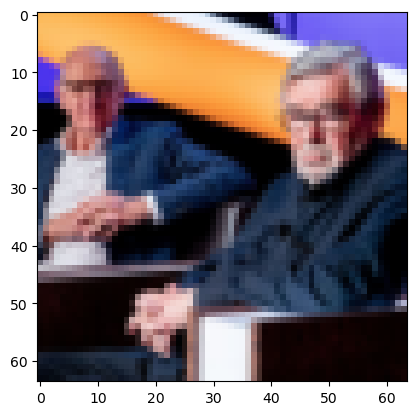

In [4]:
# Simple method to visualize images:
import matplotlib.pyplot as plt

def plot_img(img: torch.Tensor):
    plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    plt.show()

plot_img(img)

In [5]:
def add_noise(img: torch.Tensor, noise: torch.Tensor, alpha: float) -> torch.Tensor:
    """Takes original image and adds noise with closed-form formula"""
    # alpha = torch.tensor(alpha)
    return torch.sqrt(alpha) * img + torch.sqrt(1-alpha) * noise

# plot_img(add_noise(img, torch.randn_like(img), 0.05))

In [6]:
# Hyperparameters from the Denoising Diffusion Probabilistic Models:
noising_steps = 1000
beta_start = 1e-4
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, noising_steps)
alphas = 1 - betas
alphas = torch.cumprod(alphas, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013639867..1.00828].


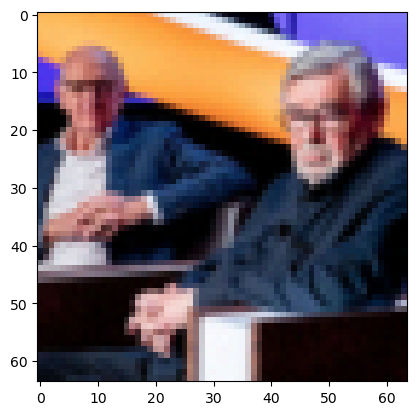

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5605972..1.4090247].


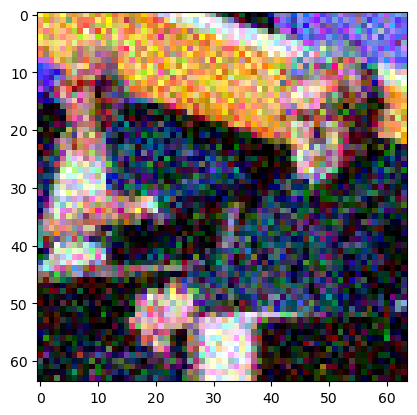

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90481603..1.7149148].


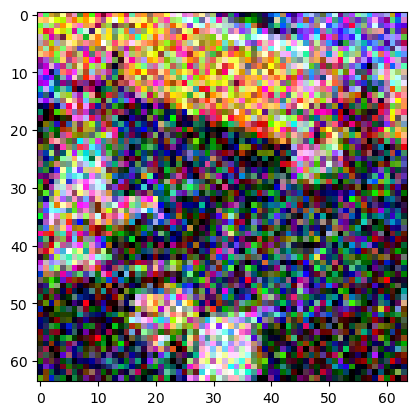

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.092658..2.214706].


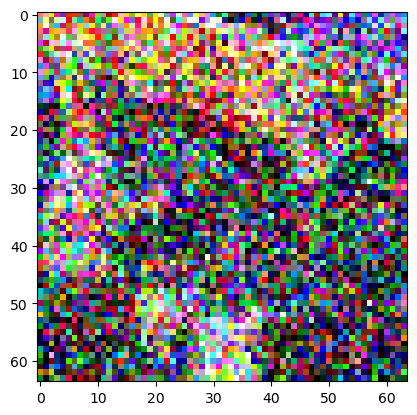

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.39831..2.2818584].


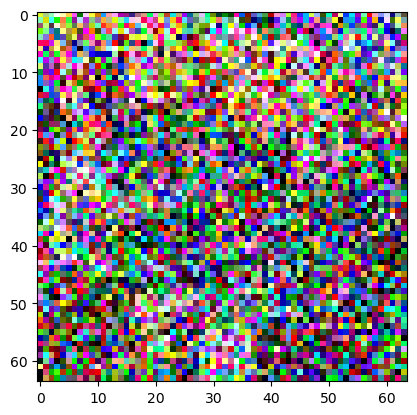

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4950341..2.4558918].


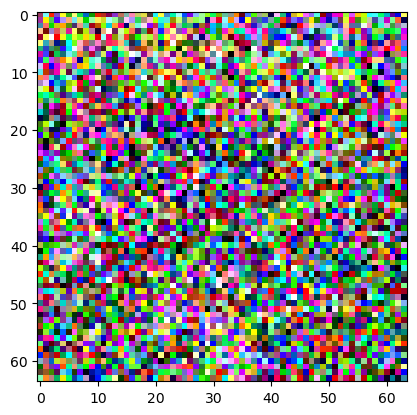

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3516943..2.2614722].


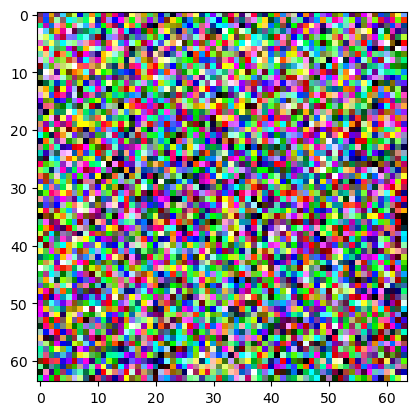

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.534303..2.4510837].


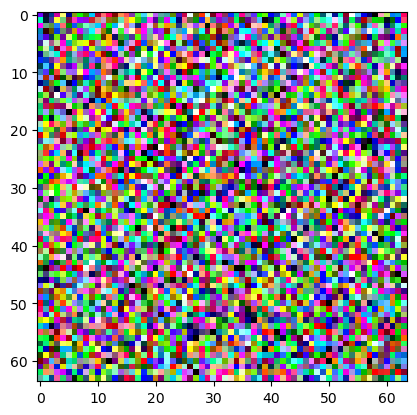

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6453846..2.4009032].


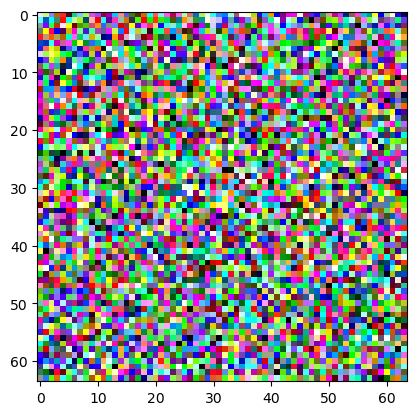

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2418706..2.233057].


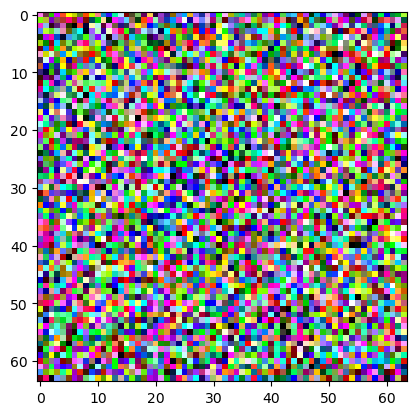

In [7]:
# Small test to see how well it works 🤓
cnt = 0
for alpha in alphas:
    if cnt % 100 == 0:
        plot_img(add_noise(img, torch.randn_like(img), alpha))
        plt.show()
    cnt += 1

## Defining the Neural Network
I will now create a simple U-Net that I can extend upon later. I will first
define the individual components, and then the overall model.

In [8]:
# Position embeddings:
# Copied this code from an earlier project I did and modified it.
# (https://github.com/jojoscholzgmailcom/Handwriting_Recognition/blob/main/hwr_package/nn/pos_enc.py)
import math


class SinCosTimeEncoding(nn.Module):
    """Adds sinusoidal position encodings to the given input embeddings.
    Closely follows the original Vaswani paper (2017). Code is very loosely
    based on https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, 
                 emb_dim: int,
                 steps: int):
        """
        Args:
            emb_dim: dimension of a single embedding vector representing time.
            
            steps: number of time steps in the diffusion process
        """
        super().__init__()

        pos_encs = torch.zeros(steps, emb_dim)
        pos = torch.arange(steps).view(steps, 1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) *
                             (-math.log(10_000.0) / emb_dim))
        pos_encs[:, 0::2] = torch.sin(pos * div_term)
        pos_encs[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pos_encs", pos_encs)
    
    def forward(self, t: torch.Tensor):
        """t: integer time for every element in the batch."""
        return self.pos_encs[t]

In [77]:
class BasicConvLayer(nn.Module):
    """Convolution and ReLu"""

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'),
            # nn.BatchNorm2d(out_channels),
            nn.GroupNorm(8, out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)

dummy = torch.randn((5, 16, 32, 32))
layer = BasicConvLayer(16, 16, 3)

print(layer(dummy).shape)

torch.Size([5, 16, 32, 32])


In [78]:
class DownConv(nn.Module):
    """Halves spatial dimensions, but doubles number of channels"""
    def __init__(self, in_channels: int, num_convs: int, kernel_size: int):
        super().__init__()

        # Convolution sequence:
        out_channels = 2 * in_channels
        self.mp = nn.MaxPool2d(2)
        self.skip = BasicConvLayer(in_channels, out_channels, 1)

        layers = []
        for _ in range(num_convs):
            layers.append(BasicConvLayer(in_channels, out_channels, kernel_size))
            in_channels = out_channels
        self.seq = nn.Sequential(*layers)

    def forward(self, x):
        x = self.mp(x)
        return self.seq(x) + self.skip(x)

In [79]:
class UpConv(nn.Module):
    """Doubles spatial dimensions, but halves number of channels"""
    def __init__(self, in_channels: int, num_convs: int, kernel_size: int):
        super().__init__()
        out_channels = in_channels // 2
        # Doing in_channels times 2 because i'll concat it with skip stuff
        self.uc = nn.ConvTranspose2d(in_channels * 2, out_channels, 2, 2)
        layers = []
        for _ in range(num_convs):
            layers.append(BasicConvLayer(out_channels, out_channels, 3))
        self.seq = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = self.uc(torch.cat([x, skip], dim=-3))
        return self.seq(x) + x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68064106..1.3088772].


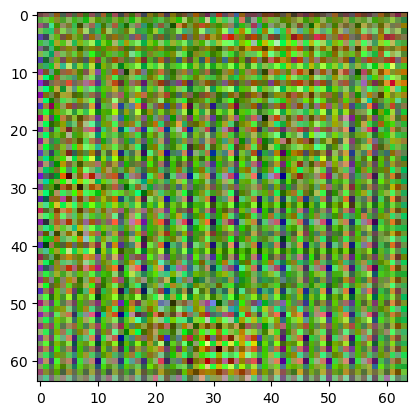

In [80]:
class SimpleUNet(nn.Module):
    """Very basic U-Net as proof of concept."""

    def __init__(self,
                 kernel_size: int,
                 init_channels: int,
                 convs_per_step: list[int],
                 input_channels: int = 3,
                 time_steps: int = 1000,
                 time_emb_dims = 128):
        super().__init__()
        
        # Initial convolution layer to get the desired initial number of channels:
        self.init_conv = BasicConvLayer(input_channels, init_channels, kernel_size)

        # Time embeddings:
        self.time_embs = SinCosTimeEncoding(time_emb_dims, time_steps)

        # Time projections part:
        self.time_projections = nn.ModuleList()
        channels = init_channels
        for n_convs in convs_per_step:
            self.time_projections.append(nn.Linear(time_emb_dims, channels))
            channels *= 2
        
        # The downsampling part:
        self.downconvs = nn.ModuleList()
        channels = init_channels
        for n_convs in convs_per_step:
            self.downconvs.append(DownConv(channels, n_convs, 3))
            channels *= 2
        
        # Right in the middle:
        self.bottleneck = nn.Sequential(
            BasicConvLayer(channels, channels, 3),
            BasicConvLayer(channels, channels, 3),
        )

        # The upsampling part:
        self.upconvs = nn.ModuleList()
        for n_convs in reversed(convs_per_step):
            self.upconvs.append(UpConv(channels, n_convs, 3))
            channels //= 2
        
        # Giving an output of the same shape as input
        self.output = nn.Conv2d(channels, input_channels, kernel_size, padding='same')

    def forward(self, x, t):
        x = self.init_conv(x)
        t = self.time_embs(t)
        
        # Getting time projections:
        time_embs = []
        for tp in self.time_projections:
            te = tp(t)
            te = te.view(*te.shape, 1, 1)
            time_embs.append(te)
        
        # Down convolutions:
        down_conv_outs = []
        for dc, te in zip(self.downconvs, time_embs):
            x = dc(x + te)
            down_conv_outs.append(x)

        x = self.bottleneck(x)
        
        for uc, dco, te in zip(self.upconvs, reversed(down_conv_outs), reversed(time_embs)):
            x = uc(x, dco) + te
        
        x = self.output(x)
        return x

unet = SimpleUNet(3, 16, [2,2,2])
plot_img(unet(img.unsqueeze(0), torch.tensor([30])).detach().squeeze())

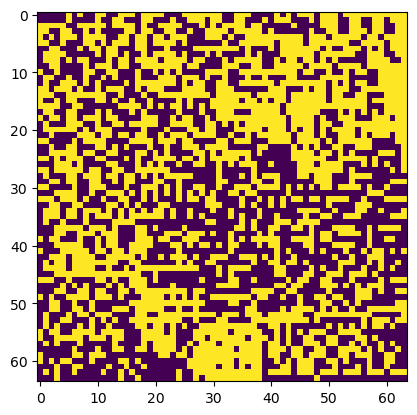

In [81]:
# Seeing if the receptive field is large enough:
img_w_grad = img.detach().clone().unsqueeze(0)
img_w_grad.requires_grad = True

out = unet(img_w_grad, torch.tensor([30])).squeeze()
out[:, 0, 0].sum().backward()

plt.imshow(img_w_grad.grad.squeeze()[0] >= 0)

## Creating the Diffusion model based on the U-Net
Defining the training objective, etc.

In [14]:
# Creating a dataset for a single datapoint
from torch.utils.data import IterableDataset, DataLoader

class SingleImgDataSet(IterableDataset):

    def __init__(self, img: torch.Tensor):
        super().__init__()
        self.img = img
    
    def __iter__(self):
        while True:
            t = torch.randint(1, noising_steps, (1,)).item()
            noise = torch.randn_like(self.img)
            yield add_noise(self.img, noise, alphas[t]), t, noise

dataset = SingleImgDataSet(img)
dataloader = DataLoader(
    dataset, 32, num_workers=4
)

imgs, ts, noises = next(iter(dataloader))

In [ ]:
# Training on the dataset
import lightning as L

class DiffusionUnet(L.LightningModule):

    def __init__(self,
                 kernel_size: int,
                 init_channels: int,
                 convs_per_step: list[int],
                 input_channels: int = 3,
                 time_steps: int = 1000,
                 time_emb_dims = 128):
        super().__init__()
        self.model = SimpleUNet(kernel_size, init_channels, convs_per_step,
                                input_channels, time_steps, time_emb_dims)
    
    def forward(self, x, t):
        return self.model(x, t)
    
    def training_step(self, batch, batch_idx):
        x, t, noise = batch
        noise_hat = self(x, t)
        loss = nn.functional.mse_loss(noise_hat, noise)
        self.log("train/mse", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters()) #, lr=5e-5)
    
    @torch.inference_mode()
    def sample_point(self):
        self.eval()

        sample = torch.randn((3, 128, 128), device=self.device)
        for t in range(noising_steps - 1, -1, -1):
            alpha = alphas[t]
            beta = betas[t]

            # TODO: check if I actually need to set noise to zero here:
            noise_hat = self(sample, t)
            noise = torch.randn_like(sample) if t > 0 else torch.zeros_like(sample)

            sample = (1 / torch.sqrt(1-beta)) * (
                sample - (beta / torch.sqrt(1 - alpha)) * noise_hat
            ) + torch.sqrt(beta) * noise
        
        return sample

In [ ]:
# Setting up the trainer
trainer = L.Trainer(
    max_time={"minutes": 10},
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True
)

In [ ]:
del unet
torch.cuda.empty_cache()

unet = DiffusionUnet(3, 32, [3,2,2,2])

In [ ]:
trainer.fit(unet, dataloader)

In [ ]:
sample = unet.sample_point()

In [ ]:
unet.to("cpu")

def remove_noise(img, noise, alpha):
    return (img - torch.sqrt(1 - alpha) * noise) / torch.sqrt(alpha)

# return = torch.sqrt(alpha) * img + torch.sqrt(1-alpha) * noise
# return / torch.sqrt(alpha) - torch.sqrt(1-alpha) * noise = img 
noise = torch.randn_like(img)
t = torch.randint(1, noising_steps, (1,)).item()
alpha = alphas[t]

noisy = add_noise(img, noise, alpha)
predicted_noise = unet(noisy.unsqueeze(0), torch.tensor([t])).squeeze().detach()

plot_img(img)
plot_img(noisy)
# plot_img(remove_noise(noisy, noise, alpha))
plot_img(remove_noise(noisy, predicted_noise, alpha))

In [ ]:
unet.to("cuda")

@torch.inference_mode()
def sample_point(model):
    model.eval()

    sample = torch.randn((4, 3, 128, 128), device=model.device)
    for t in range(noising_steps - 1, -1, -1):
        if t % 10 == 0:
            print(f"At: {t=}")
        
        ts = torch.ones((4,), dtype=torch.int, device=model.device) * t
        alpha = alphas.to(model.device)[ts]
        beta = betas.to(model.device)[ts]

        # Reshape so they work as expected:
        alpha = alpha.reshape(*alpha.shape, 1, 1, 1)
        beta = beta.reshape(*beta.shape, 1, 1, 1)

        # TODO: check if I actually need to set noise to zero here:
        noise_hat = model(sample, ts)
        noise = torch.randn_like(sample) if t > 0 else torch.zeros_like(sample)

        if (sample.isnan().any()):
            print("whoops!")
            break

        sample = torch.clamp(sample, -10, 10)

        sample = (1 / torch.sqrt(alpha)) * (
            sample - (beta / torch.sqrt(1 - alpha)) * noise_hat
        ) + torch.sqrt(beta) * noise
    
    return sample

samples = sample_point(unet)

In [ ]:
for s in samples:
    plot_img(s.cpu())

## Small experiment
Am having problems. Seeing how the model trains when it literally has to predict
just the input.

In [83]:
# Creating a dataset for a single datapoint
from torch.utils.data import IterableDataset, DataLoader

class SingleImgDataSet(IterableDataset):

    def __init__(self, img: torch.Tensor):
        super().__init__()
        self.img = img
    
    def __iter__(self):
        while True:
            t = torch.randint(1, noising_steps, (1,)).item() * 0
            noise = torch.randn_like(self.img)
            yield noise, t, noise

dataset = SingleImgDataSet(img)
dataloader = DataLoader(
    dataset, 64, num_workers=4
)

imgs, ts, noises = next(iter(dataloader))

In [89]:
# Setting up the trainer
trainer = L.Trainer(
    max_time={"minutes": 10},
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True
)
del unet
torch.cuda.empty_cache()

unet = DiffusionUnet(3, 32, [1])
trainer.fit(unet, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | SimpleUNet | 126 K  | train
---------------------------------------------
126 K     Trainable params
0         Non-trainable params
126 K     Total params
0.507     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 55/? [00:01<00:00, 29.89it/s, train/mse=0.636]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17929965..1.1712465].


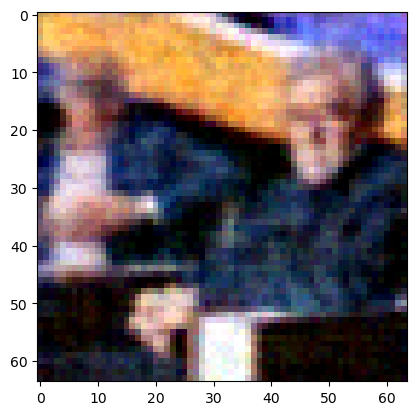

In [73]:
unet.eval()
noise = torch.randn_like(img).unsqueeze(0)

plot_img(unet(noise, torch.tensor([0])).squeeze().detach())